# Image Segmentation: Camvid

Brostow et al., 2008

Fastai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
camvid = untar_data(URLs.CAMVID)
camvid.ls

<bound method <lambda> of PosixPath('/home/jupyter/.fastai/data/camvid')>

In [4]:
images = camvid/'images'
images_lbl = camvid/'labels'

In [5]:
file_names = get_image_files(images)

In [6]:
# doc(get_image_files)

In [7]:
file_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_01680.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_06630.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_009120.png')]

In [8]:
label_names = get_image_files(images_lbl)

In [9]:
label_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009720_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0006R0_f03930_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_01110_P.png')]

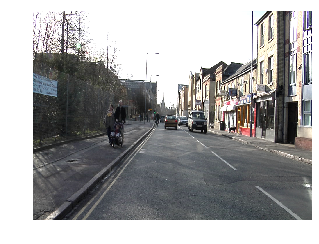

In [10]:
test_img = file_names[0]
img = open_image(test_img)
img.show(figsize=(5,5))

In [11]:
get_y_fn = lambda x: images_lbl/f'{x.stem}_P{x.suffix}'

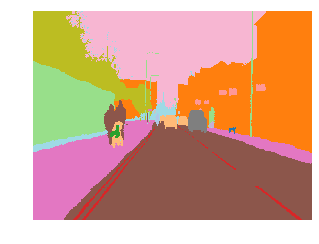

In [12]:
mask = open_mask(get_y_fn(test_img))
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [14]:
codes = np.loadtxt(camvid/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

# Datasets

In [15]:
size = src_size//2
bs=4

In [16]:
src = (SegmentationItemList.from_folder(images)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [17]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

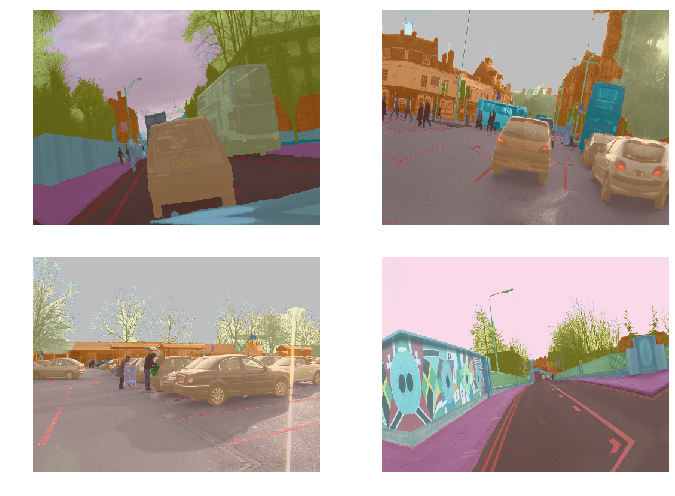

In [18]:
data.show_batch(2, figsize=(10, 7))

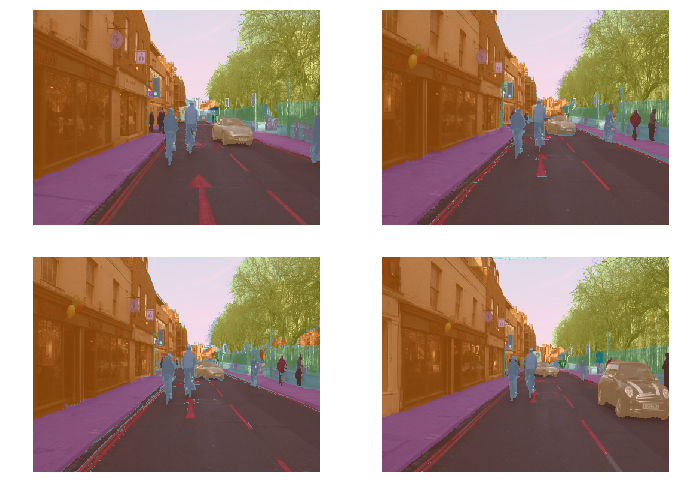

In [19]:
data.show_batch(2, figsize=(10, 7), ds_type=DatasetType.Valid)

# Model

In [20]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
        target = target.squeeze(1)
        mask = target != void_code
        return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [21]:
metrics=acc_camvid

In [22]:
wd=1e-2

In [23]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


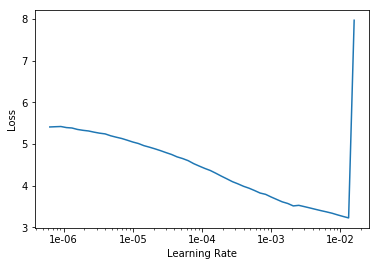

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=3e-4

In [26]:
learn.fit_one_cycle(10, slice(lr), pct_start=.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.482119,0.982172,0.778213,01:50
1,0.928248,0.708914,0.824981,01:50
2,0.749314,0.627416,0.834105,01:50
3,0.620563,0.587516,0.835125,01:51
4,0.577695,0.481534,0.866627,01:51
5,0.563320,0.455003,0.868410,01:50
6,0.520290,0.396021,0.888108,01:50
7,0.491583,0.405410,0.889833,01:50
8,0.466075,0.331930,0.907392,01:50
9,0.389635,0.326524,0.905995,01:50


In [27]:
learn.save('stage-1')

In [28]:
learn.destroy()
size = src_size
bs = 1

this Learner object self-destroyed - it still exists, but no longer usable


In [29]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

In [30]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [31]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/jupyter/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/jupyter/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [32]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


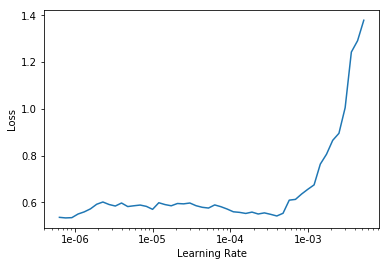

In [33]:
lr_find(learn)
learn.recorder.plot()

In [34]:
lr=3e-6

In [35]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.547945,0.374614,0.897401,08:01
1,0.532778,0.364854,0.898475,08:00
2,0.528449,0.358128,0.900297,08:00
3,0.473729,0.353549,0.902212,08:00
4,0.449440,0.352756,0.901704,08:00
5,0.455211,0.340190,0.905887,07:59
6,0.420901,0.345747,0.904603,08:00
7,0.409243,0.333162,0.906447,08:00
8,0.384247,0.325121,0.908592,08:00
9,0.391067,0.329342,0.906869,08:00


In [36]:
learn.save('stage-2-big')